# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Behavioral-Cloning

In [1]:
import os
import csv
import cv2
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

data_path = 'record'


samples = []
with open( data_path + '/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)


train_samples, validation_samples = train_test_split(samples, test_size=0.2)


def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                def get_image_path(row):
                    return data_path + '/IMG/'+batch_sample[row].split('/')[-1]
                
                def read_image(path):
                    img = cv2.imread(path)
                    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                center_image_path = get_image_path(0) 
                left_image_path =  get_image_path(1)
                right_image_path =  get_image_path(2)
                
                center_image = read_image(center_image_path)
                left_image = read_image(left_image_path)
                right_image = read_image(right_image_path)
                
                correction = 0.25 # this is a parameter to tune
                center_angle = float(batch_sample[3])
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                fliped_center_image = cv2.flip(center_image, 1)
                fliped_center_angle = center_angle*-1.0
                
                images.extend((center_image, left_image, right_image, fliped_center_image))
                angles.extend((center_angle, left_angle, right_angle, fliped_center_angle))

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

ch, row, col = 3, 80, 320  # Trimmed image format

In [2]:
from keras.models import Sequential, Model
from keras.layers import Cropping2D, Lambda, Convolution2D, Flatten, Dense, Dropout
import tensorflow as tf
import cv2

def resize_image(x):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(x, (66, 200))

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Lambda(resize_image))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation ="relu"))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation ="relu"))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation ="relu"))
model.add(Convolution2D(64,3,3,  activation ="relu"))
model.add(Convolution2D(64,3,3,  activation ="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dropout(0.7))
model.add(Dense(10))
model.add(Dropout(0.7))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.summary()
history_object = model.fit_generator(train_generator, samples_per_epoch= 
            len(train_samples), validation_data=validation_generator, 
            nb_val_samples=len(validation_samples), nb_epoch=40)


model.save("model.h5")    

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 65, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 66, 200, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_2[0][0]                   
___________________________________________________________________________________________

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


10112/10102 [==============================] - 29s - loss: 0.0811 - val_loss: 0.0805
Epoch 2/40
10112/10102 [==============================] - 23s - loss: 0.0744 - val_loss: 0.0657
Epoch 3/40
10112/10102 [==============================] - 26s - loss: 0.0791 - val_loss: 0.0736
Epoch 4/40
10200/10102 [==============================] - 28s - loss: 0.0674 - val_loss: 0.0620
Epoch 5/40
10112/10102 [==============================] - 19s - loss: 0.0647 - val_loss: 0.0502
Epoch 6/40
10112/10102 [==============================] - 19s - loss: 0.0630 - val_loss: 0.0526
Epoch 7/40
10112/10102 [==============================] - 19s - loss: 0.0672 - val_loss: 0.0637
Epoch 8/40
10200/10102 [==============================] - 19s - loss: 0.0620 - val_loss: 0.0553
Epoch 9/40
10112/10102 [==============================] - 19s - loss: 0.0601 - val_loss: 0.0514
Epoch 10/40
10112/10102 [==============================] - 19s - loss: 0.0615 - val_loss: 0.0537
Epoch 11/40
10112/10102 [=========================

dict_keys(['loss', 'val_loss'])


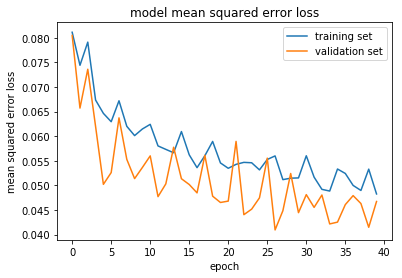

In [3]:
from keras.models import Model
import matplotlib.pyplot as plt


### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()